In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
df = pd.read_csv("FuelPriceData.csv")

# Function to convert the 'YYYYM#' date format to datetime objects
def parse_date(date_str):
    """Converts 'YYYYM#' to 'YYYY-MM-01' datetime object."""
    year = date_str[:4]
    month = date_str[5:]
    return pd.to_datetime(f'{year}-{month}-01')

# Apply date conversion and set as index
df['Date'] = df['Date'].apply(parse_date)
df = df.set_index('Date')

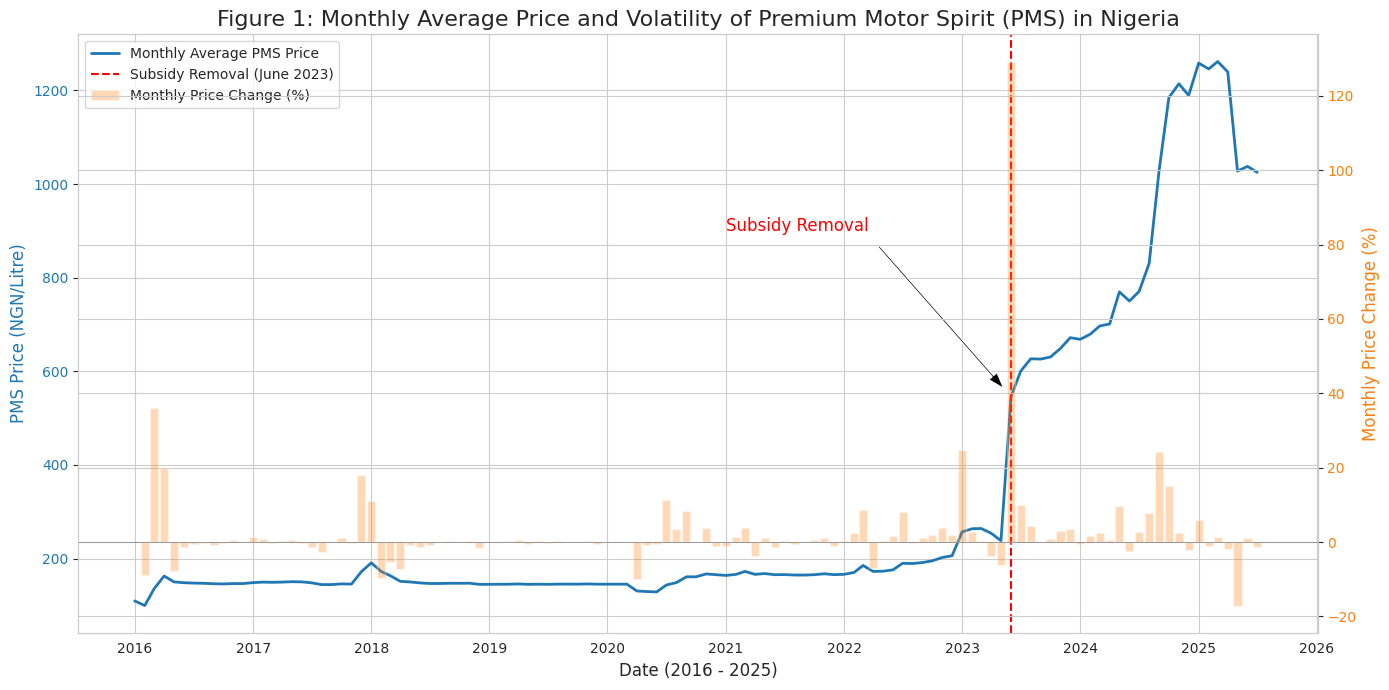

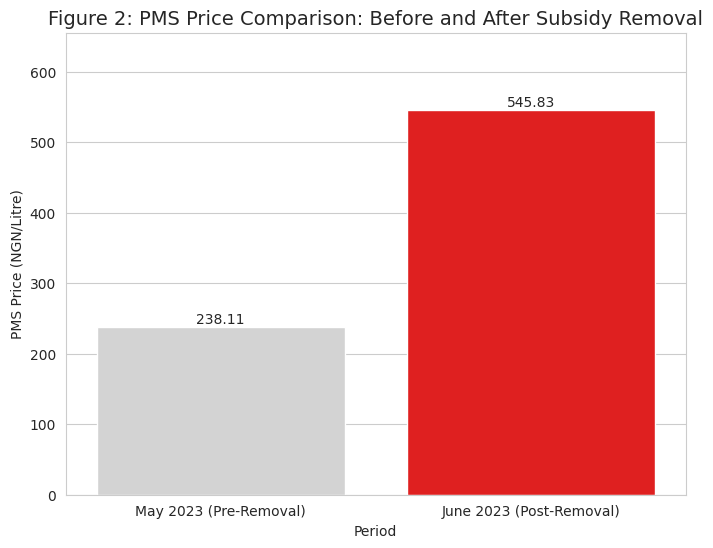

In [28]:
# Select and rename the price column
price_df = df[['Value']].copy()
price_df.rename(columns={'Value': 'PMS_Price_NGN'}, inplace=True)

# Calculate Monthly Percentage Change (Volatility)
price_df['Monthly_Change_%'] = price_df['PMS_Price_NGN'].pct_change() * 100

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary Y-axis: PMS Price Trend
color = 'tab:blue'
ax1.set_xlabel('Date (2016 - 2025)', fontsize=12)
ax1.set_ylabel('PMS Price (NGN/Litre)', color=color, fontsize=12)
ax1.plot(price_df.index, price_df['PMS_Price_NGN'], color=color, linewidth=2, label='Monthly Average PMS Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Figure 1: Monthly Average Price and Volatility of Premium Motor Spirit (PMS) in Nigeria', fontsize=16)

# Highlight the Subsidy Removal Event (June 2023)
subsidy_removal_date = pd.to_datetime('2023-06-01')

# Safely get the price at the removal date
if subsidy_removal_date in price_df.index:
    subsidy_removal_price = price_df.loc[subsidy_removal_date]['PMS_Price_NGN']
    ax1.axvline(subsidy_removal_date, color='red', linestyle='--', linewidth=1.5, label='Subsidy Removal (June 2023)')
    ax1.annotate('Subsidy Removal', xy=(subsidy_removal_date, subsidy_removal_price),
                 xytext=(pd.to_datetime('2021-01-01'), 900),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                 fontsize=12, color='red')

# Secondary Y-axis: Monthly Price Change (Volatility)
ax2 = ax1.twinx()  # Secondary axis
color = 'tab:orange'
ax2.set_ylabel('Monthly Price Change (%)', color=color, fontsize=12)
ax2.bar(price_df.index, price_df['Monthly_Change_%'], color=color, alpha=0.3, width=25, label='Monthly Price Change (%)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5)

# Format x-axis dates
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(1))
plt.xticks(rotation=45)

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()
plt.close()



# Filter data for prices right before and after the removal (May and June 2023)
pre_removal_date = pd.to_datetime('2023-05-01')
post_removal_date = pd.to_datetime('2023-06-01')


if pre_removal_date in price_df.index and post_removal_date in price_df.index:
    pre_removal_price = price_df.loc[pre_removal_date]['PMS_Price_NGN']
    post_removal_price = price_df.loc[post_removal_date]['PMS_Price_NGN']

    change_df = pd.DataFrame({
        'Period': ['May 2023 (Pre-Removal)', 'June 2023 (Post-Removal)'],
        'Price': [pre_removal_price, post_removal_price]
    })

    plt.figure(figsize=(8, 6))
    
    # Using the fixed code to avoid FutureWarning
    sns.barplot(x='Period', y='Price', data=change_df, hue='Period', 
                palette={'May 2023 (Pre-Removal)': 'lightgray', 'June 2023 (Post-Removal)': 'red'},
                legend=False)

    plt.title('Figure 2: PMS Price Comparison: Before and After Subsidy Removal', fontsize=14)
    plt.ylabel('PMS Price (NGN/Litre)')
    plt.xlabel('Period')

    # Add data labels
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.2f')

    plt.ylim(0, post_removal_price * 1.2)
    plt.show()
    plt.close()

In [29]:
import pandas as pd
import numpy as np

# Load CPI
df_cpi = pd.read_csv('Composite-Consumer_Price_Index.csv')
df_cpi['date'] = pd.to_datetime(df_cpi['Time'], format='%b %Y')
df_cpi = df_cpi.set_index('date').sort_index()
df_cpi.rename(columns={'12-Month average change (%)': 'inflation_rate', '12-Month Average': 'cpi_index'}, inplace=True)

# Fill missing CPI index using YoY inflation
for i in range(len(df_cpi)):
    if pd.isna(df_cpi.iloc[i]['cpi_index']):
        prev_date = df_cpi.index[i] - pd.DateOffset(months=12)
        if prev_date in df_cpi.index:
            prev_index = df_cpi.loc[prev_date]['cpi_index']
            inflation = df_cpi.iloc[i]['inflation_rate'] / 100
            df_cpi.at[df_cpi.index[i], 'cpi_index'] = prev_index * (1 + inflation)

# Load Fuel
df_fuel = pd.read_csv('Fuel-Prices.csv')
df_fuel['date'] = pd.to_datetime(df_fuel['Date'], format='%b %Y')
df_fuel = df_fuel.set_index('date')['Value (NGN per Litre)'].to_frame(name='fuel_price')

# Load Transport
df_trans = pd.read_csv('Transport-Prices.csv')
df_trans['date'] = pd.to_datetime(df_trans['Month'], format='%b-%y')
df_trans = df_trans.set_index('date')
df_trans.rename(columns={
    'Bus journey within  city , per  drop constant  route (NGN)': 'bus_within',
    'Bus journey intercity, state route, charge per drop (NGN)': 'bus_inter',
    'Journey by motorcycle (okada) per drop (NGN)': 'motorcycle'
}, inplace=True)

# Determine full date range
min_date = min(df_cpi.index.min(), df_fuel.index.min(), df_trans.index.min())
max_date = max(df_cpi.index.max(), df_fuel.index.max(), df_trans.index.max())
full_dates = pd.date_range(min_date, max_date, freq='MS')

# Reindex and interpolate each
df_fuel = df_fuel.reindex(full_dates).interpolate(method='linear')
df_trans = df_trans.reindex(full_dates).interpolate(method='linear')

# Merge
df = pd.concat([df_cpi['cpi_index'], df_fuel, df_trans], axis=1)

# Convert to real terms (base: first CPI)
base_cpi = df['cpi_index'].iloc[0]
df['real_fuel'] = df['fuel_price'] * (base_cpi / df['cpi_index'])
df['real_bus_within'] = df['bus_within'] * (base_cpi / df['cpi_index'])
df['real_bus_inter'] = df['bus_inter'] * (base_cpi / df['cpi_index'])
df['real_motorcycle'] = df['motorcycle'] * (base_cpi / df['cpi_index'])

# Normalize to base 100 at start for comparison
base_fuel = df['real_fuel'].iloc[0]
base_bus_within = df['real_bus_within'].iloc[0]
base_bus_inter = df['real_bus_inter'].iloc[0]
base_motorcycle = df['real_motorcycle'].iloc[0]

df['norm_fuel'] = (df['real_fuel'] / base_fuel) * 100
df['norm_bus_within'] = (df['real_bus_within'] / base_bus_within) * 100
df['norm_bus_inter'] = (df['real_bus_inter'] / base_bus_inter) * 100
df['norm_motorcycle'] = (df['real_motorcycle'] / base_motorcycle) * 100

# Reset index to include date as a column
df = df.reset_index().rename(columns={'index': 'date'})

# Save to CSV
df.to_csv('processed.csv', index=False)
print("Processed data with date column saved to 'processed.csv'")

Processed data with date column saved to 'processed.csv'


/tmp/ipykernel_12666/3650456517.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_trans = df_trans.reindex(full_dates).interpolate(method='linear')


In [30]:
# analytical_methods.py
# This script performs correlation analysis, regression modeling, and trend analysis (statistical summary).

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Load processed data
df = pd.read_csv('processed.csv', index_col='date', parse_dates=True)

# Correlation Analysis
corr_matrix = df[['real_fuel', 'real_bus_within', 'real_bus_inter', 'real_motorcycle']].corr()
print("Correlation Matrix:")
print(corr_matrix)

print("\nSpecific Correlations with Fuel:")
print(f"Fuel vs Bus Within: {corr_matrix.loc['real_fuel', 'real_bus_within']}")
print(f"Fuel vs Bus Inter: {corr_matrix.loc['real_fuel', 'real_bus_inter']}")
print(f"Fuel vs Motorcycle: {corr_matrix.loc['real_fuel', 'real_motorcycle']}")

# Regression Model (predict each transport based on fuel)
reg_results = {}
for target in ['real_bus_within', 'real_bus_inter', 'real_motorcycle']:
    X = df['real_fuel'].values.reshape(-1, 1)
    y = df[target].values
    model = LinearRegression()
    model.fit(X, y)
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    reg_results[target] = {
        'coef': model.coef_[0],
        'intercept': model.intercept_,
        'r2': r2
    }
    print(f"\nRegression for {target}:")
    print(f"Coefficient: {model.coef_[0]}")
    print(f"Intercept: {model.intercept_}")
    print(f"R-squared: {r2}")

# Trend Analysis (e.g., annual means, growth rates)
df['year'] = df.index.year
annual_means = df.groupby('year')[['real_fuel', 'real_bus_within', 'real_bus_inter', 'real_motorcycle']].mean()
print("\nAnnual Means:")
print(annual_means)

# Compute year-over-year growth for each
annual_growth = annual_means.pct_change() * 100
print("\nAnnual Growth Rates (%):")
print(annual_growth)

Correlation Matrix:
                 real_fuel  real_bus_within  real_bus_inter  real_motorcycle
real_fuel         1.000000         0.395791        0.701782         0.130096
real_bus_within   0.395791         1.000000        0.822652         0.904646
real_bus_inter    0.701782         0.822652        1.000000         0.660895
real_motorcycle   0.130096         0.904646        0.660895         1.000000

Specific Correlations with Fuel:
Fuel vs Bus Within: 0.3957905960264859
Fuel vs Bus Inter: 0.7017817509144512
Fuel vs Motorcycle: 0.1300955396282911

Regression for real_bus_within:
Coefficient: 0.6493691682966777
Intercept: 99.77458443612649
R-squared: 0.156650195903001

Regression for real_bus_inter:
Coefficient: 4.3402002292141635
Intercept: 829.9764510186043
R-squared: 0.49249762591655355

Regression for real_motorcycle:
Coefficient: 0.10603057635957852
Intercept: 102.83404863712185
R-squared: 0.01692484943117656

Annual Means:
       real_fuel  real_bus_within  real_bus_inter  real_

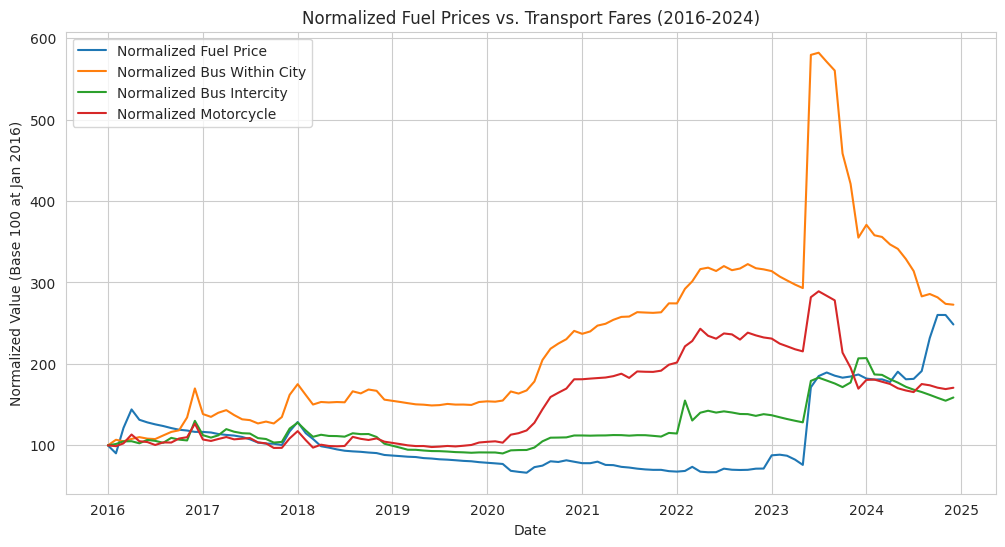

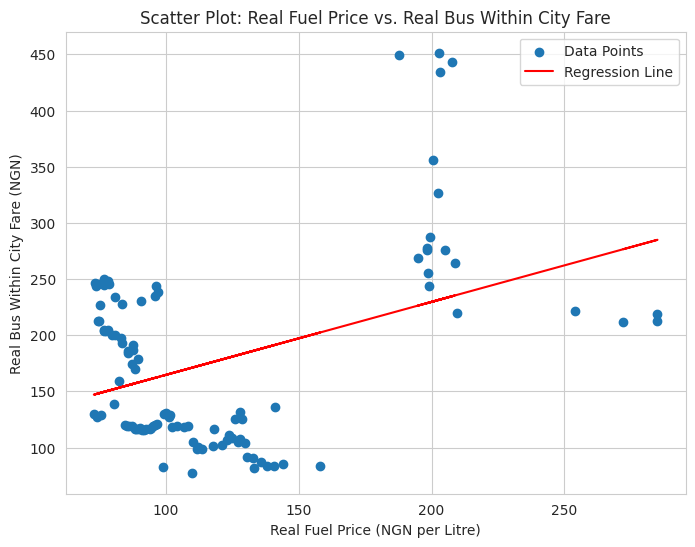

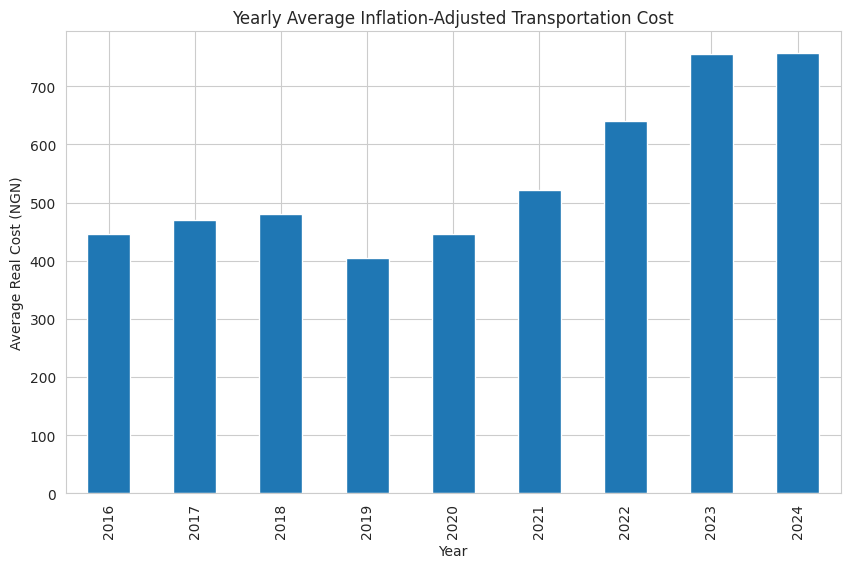

In [31]:
# visualizations.py
# This script creates the specified visualizations using matplotlib.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load processed data
df = pd.read_csv('processed.csv', index_col='date', parse_dates=True)

# Line Chart: Fuel prices vs. transport fares (normalized for comparison, 2016-2024)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['norm_fuel'], label='Normalized Fuel Price')
plt.plot(df.index, df['norm_bus_within'], label='Normalized Bus Within City')
plt.plot(df.index, df['norm_bus_inter'], label='Normalized Bus Intercity')
plt.plot(df.index, df['norm_motorcycle'], label='Normalized Motorcycle')
plt.title('Normalized Fuel Prices vs. Transport Fares (2016-2024)')
plt.xlabel('Date')
plt.ylabel('Normalized Value (Base 100 at Jan 2016)')
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot with Regression Line: Fuel price vs. bus fare (using bus within as example)
X = df['real_fuel'].values.reshape(-1, 1)
y = df['real_bus_within'].values
model = LinearRegression()
model.fit(X, y)
preds = model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(df['real_fuel'], df['real_bus_within'], label='Data Points')
plt.plot(df['real_fuel'], preds, color='red', label='Regression Line')
plt.title('Scatter Plot: Real Fuel Price vs. Real Bus Within City Fare')
plt.xlabel('Real Fuel Price (NGN per Litre)')
plt.ylabel('Real Bus Within City Fare (NGN)')
plt.legend()
plt.grid(True)
plt.show()

# Bar Chart: Yearly average inflation-adjusted transportation cost (average of all transport types)
df['avg_real_transport'] = df[['real_bus_within', 'real_bus_inter', 'real_motorcycle']].mean(axis=1)
df['year'] = df.index.year
yearly_avg = df.groupby('year')['avg_real_transport'].mean()

plt.figure(figsize=(10, 6))
yearly_avg.plot(kind='bar')
plt.title('Yearly Average Inflation-Adjusted Transportation Cost')
plt.xlabel('Year')
plt.ylabel('Average Real Cost (NGN)')
plt.grid(True)
plt.show()